# Análise do Risco de Crédito

Este notebook tem como objetivo **analisar os fatores que influenciam a inadimplência**
dos clientes, utilizando os dados consolidados no Data Warehouse.

As análises realizadas visam responder às perguntas de negócio definidas
na etapa de planejamento do MVP.


In [0]:
df_fact = spark.table("mvp_bank.gold.fato_credit_risk")
df_customer = spark.table("mvp_bank.gold.dim_customer")
df_home = spark.table("mvp_bank.gold.dim_home")
df_employment = spark.table("mvp_bank.gold.dim_employment")
df_intent = spark.table("mvp_bank.gold.dim_intent")

(
    df_fact
    .orderBy("fact_id")
    .limit(20)
    .display()
)


fact_id,customer_sk,home_sk,employment_sk,intent_sk,loan_amnt,loan_int_rate,loan_percent_income,loan_status,cb_person_default_on_file,cb_person_cred_hist_length,ingestion_ts
0,735,4,8,10,18000,13.57,0.41,1,Y,4,2025-12-17T20:46:15.044Z
1,3123,3,4,11,12000,14.83,0.3,0,N,4,2025-12-17T20:46:15.044Z
2,1334,4,1,22,4600,6.03,0.17,0,N,3,2025-12-17T20:46:15.044Z
3,572,4,4,37,5000,10.0,0.16,0,N,2,2025-12-17T20:46:15.044Z
4,1771,4,4,10,5000,13.47,0.08,0,Y,2,2025-12-17T20:46:15.044Z
5,1622,1,1,22,10000,8.59,0.19,0,N,2,2025-12-17T20:46:15.044Z
6,3211,1,10,4,12000,16.89,0.24,1,N,4,2025-12-17T20:46:15.044Z
7,1679,1,8,8,12000,5.42,0.21,0,N,2,2025-12-17T20:46:15.044Z
8,816,4,8,23,4250,12.69,0.09,0,N,4,2025-12-17T20:46:15.044Z
9,3999,1,5,22,11000,7.9,0.15,1,N,3,2025-12-17T20:46:15.044Z


## Avaliação da Qualidade dos Dados

A qualidade dos dados foi avaliada por meio da verificação de valores nulos,
estatísticas descritivas e distribuição das variáveis.

Após os tratamentos realizados na camada Silver, os dados apresentaram
consistência adequada para análise, não sendo identificados problemas
que comprometessem os resultados obtidos.


In [0]:
from pyspark.sql.functions import col, sum

df_null = df_fact.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df_fact.columns
])

df_null.display()


fact_id,customer_sk,home_sk,employment_sk,intent_sk,loan_amnt,loan_int_rate,loan_percent_income,loan_status,cb_person_default_on_file,cb_person_cred_hist_length,ingestion_ts
0,0,0,0,0,0,3116,0,0,0,0,0


In [0]:
df_fact.describe().display()


summary,fact_id,customer_sk,home_sk,employment_sk,intent_sk,loan_amnt,loan_int_rate,loan_percent_income,loan_status,cb_person_default_on_file,cb_person_cred_hist_length
count,32581,32581,32581,32581,32581,32581,29465,32581,32581,32581,32581
mean,16290.0,4261.97845370001,2.6762223381725545,5.652282004849452,19.95506583591664,9589.371105859243,11.011694834508658,0.17020349294325227,0.21816396059052823,null,5.804211043246064
stddev,9405.468896693385,2712.2629254369203,1.4331156355876191,4.058639024540195,12.164929889893385,6322.086645792363,3.240459475983928,0.10678175638642143,0.4130056685601505,null,4.055001164712731
min,0,1,1,1,1,500,5.42,0.0,0,N,2
max,32580,10195,4,36,42,35000,23.22,0.83,1,Y,30


## Interpretação dos Resultados

Os resultados indicam que fatores como idade, renda, finalidade do empréstimo
e taxa de juros possuem forte relação com a inadimplência.

Clientes com menor renda, menor tempo de emprego e empréstimos com taxas
mais elevadas apresentaram maior risco de crédito.


In [0]:
spark.sql("""
SELECT loan_status, COUNT(*) AS qtd
FROM mvp_bank.gold.fato_credit_risk
GROUP BY loan_status
ORDER BY loan_status
""").display()


loan_status,qtd
0,25473
1,7108


In [0]:
%sql
SELECT 
  CASE 
    WHEN c.person_age < 25 THEN 'Menor de 25'
    WHEN c.person_age BETWEEN 25 AND 40 THEN '25 a 40'
    WHEN c.person_age BETWEEN 41 AND 60 THEN '41 a 60'
    ELSE 'Acima de 60'
  END AS faixa_etaria,
  COUNT(*) AS total,
  SUM(f.loan_status) AS inadimplentes,
  ROUND(SUM(f.loan_status)/COUNT(*), 2) AS taxa_inadimplencia
FROM mvp_bank.gold.fato_credit_risk f
JOIN mvp_bank.gold.dim_customer c ON f.customer_sk = c.customer_sk
GROUP BY 1
ORDER BY taxa_inadimplencia DESC;


faixa_etaria,total,inadimplentes,taxa_inadimplencia
Acima de 60,70,17.0,0.24
Menor de 25,12315,2860.0,0.23
41 a 60,1424,302.0,0.21
25 a 40,18772,3929.0,0.21


In [0]:
%sql
SELECT
  CASE
    WHEN c.person_income < 30000 THEN 'Baixa'
    WHEN c.person_income BETWEEN 30000 AND 60000 THEN 'Média'
    ELSE 'Alta'
  END AS faixa_renda,
  COUNT(*) AS total,
  SUM(f.loan_status) AS inadimplentes,
  ROUND(SUM(f.loan_status)/COUNT(*), 2) AS taxa_inadimplencia
FROM mvp_bank.gold.fato_credit_risk f
JOIN mvp_bank.gold.dim_customer c ON f.customer_sk = c.customer_sk
GROUP BY 1
ORDER BY taxa_inadimplencia DESC;


faixa_renda,total,inadimplentes,taxa_inadimplencia
Baixa,3669,1727.0,0.47
Média,15057,3694.0,0.25
Alta,13855,1687.0,0.12


In [0]:
%sql
SELECT 
  i.loan_intent AS tipo_emprestimo,
  COUNT(*) AS total,
  SUM(f.loan_status) AS inadimplentes,
  ROUND(SUM(f.loan_status)/COUNT(*), 2) AS taxa_inad
FROM mvp_bank.gold.fato_credit_risk f
JOIN mvp_bank.gold.dim_intent i ON f.intent_sk = i.intent_sk
GROUP BY i.loan_intent
ORDER BY taxa_inad DESC;


tipo_emprestimo,total,inadimplentes,taxa_inad
DEBTCONSOLIDATION,5212,1490.0,0.29
MEDICAL,6071,1621.0,0.27
HOMEIMPROVEMENT,3605,941.0,0.26
PERSONAL,5521,1098.0,0.2
EDUCATION,6453,1111.0,0.17
VENTURE,5719,847.0,0.15


In [0]:
%sql
SELECT 
  ROUND(f.loan_int_rate, 1) AS taxa_juros,
  COUNT(*) AS total,
  SUM(f.loan_status) AS inadimplentes,
  ROUND(SUM(f.loan_status)/COUNT(*), 2) AS taxa_inad
FROM mvp_bank.gold.fato_credit_risk f
GROUP BY 1
ORDER BY 1;


taxa_juros,total,inadimplentes,taxa_inad
null,3116,644.0,0.21
5.4,594,30.0,0.05
5.8,395,20.0,0.05
6.0,818,58.0,0.07
6.2,214,18.0,0.08
6.4,63,3.0,0.05
6.5,250,36.0,0.14
6.6,414,46.0,0.11
6.8,179,10.0,0.06
6.9,472,52.0,0.11


In [0]:
%sql
SELECT 
  e.person_emp_length AS tempo_emprego,
  COUNT(*) AS total,
  SUM(f.loan_status) AS inadimplentes,
  ROUND(SUM(f.loan_status)/COUNT(*), 2) AS taxa_inad
FROM mvp_bank.gold.fato_credit_risk f
JOIN mvp_bank.gold.dim_employment e ON f.employment_sk = e.employment_sk
GROUP BY 1
ORDER BY tempo_emprego;


tempo_emprego,total,inadimplentes,taxa_inad
0.0,5000,1429.0,0.29
1.0,2915,806.0,0.28
2.0,3849,987.0,0.26
3.0,3456,696.0,0.2
4.0,2874,610.0,0.21
5.0,2946,548.0,0.19
6.0,2666,500.0,0.19
7.0,2196,412.0,0.19
8.0,1687,281.0,0.17
9.0,1367,244.0,0.18


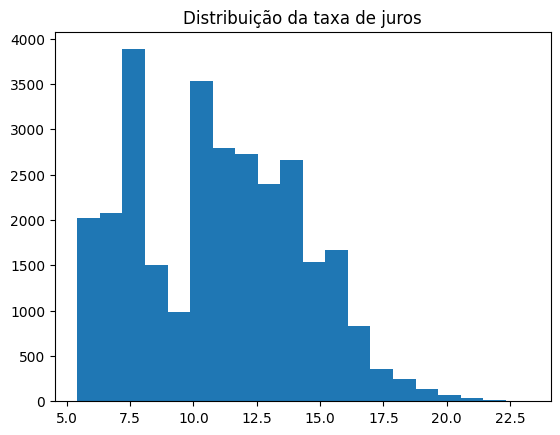

In [0]:
import matplotlib.pyplot as plt

pdf = df_fact.toPandas()
plt.hist(pdf['loan_int_rate'], bins=20)
plt.title("Distribuição da taxa de juros")
plt.show()


## Conclusão

O pipeline de dados construído permitiu extrair, transformar, modelar e analisar
dados de risco de crédito de forma estruturada e reprodutível.

A solução atende aos objetivos definidos inicialmente, fornecendo insights
relevantes para apoio à tomada de decisão no contexto bancário.
